# Ejemplo de algoritmos Bug

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/6-Planificacion-Movimiento/6-01-Algoritmos-bug.ipynb)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Si no se utiliza Google Colab se puede ejecutar la siguiente línea
# %matplotlib qt

**Obstáculos del entorno**

Los obstáculos que se encuentran el entorno el robot están compuestos por bordes definidos en este caso como una secuencia arbitraria de puntos. En este caso, se generará los componentes X, Y de los puntos que definen los obstáculos

In [6]:
# Clase que contiene los obstáculos como un conjunto de puntos
class EntornoObstaculos:
    def __init__(self):
        self.obst_x = []
        self.obst_y = []

    def add(self, obs_x, obs_y):
        for i in range(obs_x[0], obs_x[1]):
            for j in range(obs_y[0], obs_y[1]):
                self.obst_x.append(i)
                self.obst_y.append(j)
    
    def getxy(self):
        return (self.obst_x, self.obst_y)

obstaculo = EntornoObstaculos()
obstaculo.add((20, 40), (20, 40))
obstaculo.add((60, 100), (40, 80))
obstaculo.add((120, 140), (80, 100))
obstaculo.add((80, 140), (0, 20))
obstaculo.add((0, 20), (60, 100))
obstaculo.add((20, 40), (80, 100))
obstaculo.add((120, 160), (40, 60))

obst_xy = obstaculo.getxy()

Visualización de los obstáculos

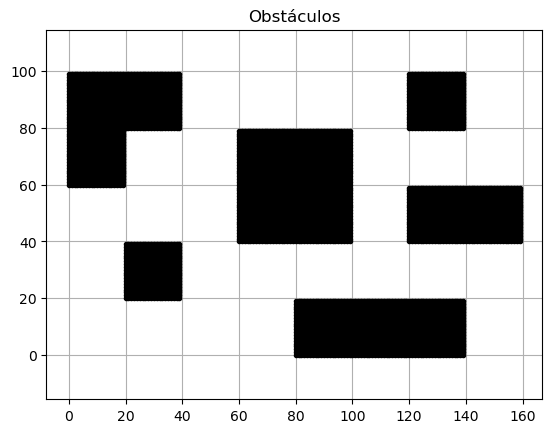

In [7]:
plt.plot(obst_xy[0], obst_xy[1], ".k")
plt.grid(True); plt.axis('equal')
plt.title('Obstáculos')
plt.show()

## BugPlanner general

In [8]:
class BugPlanner:
    def __init__(self, x_start, y_start, x_goal, y_goal, x_obs, y_obs):
        self.x_goal = x_goal; self.y_goal = y_goal
        self.x_obs = x_obs; self.y_obs = y_obs
        self.r_x = [x_start]
        self.r_y = [y_start]
        self.out_x = []
        self.out_y = []
        for o_x, o_y in zip(x_obs, y_obs):
            for add_x, add_y in zip([1, 0, -1, -1, -1, 0, 1, 1],
                                    [1, 1, 1, 0, -1, -1, -1, 0]):
                cand_x, cand_y = o_x+add_x, o_y+add_y
                valid_point = True
                for _x, _y in zip(x_obs, y_obs):
                    if cand_x == _x and cand_y == _y:
                        valid_point = False
                        break
                if valid_point:
                    self.out_x.append(cand_x), self.out_y.append(cand_y)

    def mov_normal(self):
        return self.r_x[-1] + np.sign(self.x_goal - self.r_x[-1]), \
               self.r_y[-1] + np.sign(self.y_goal - self.r_y[-1])

    def mov_to_next_obs(self, visited_x, visited_y):
        for add_x, add_y in zip([1, 0, -1, 0], [0, 1, 0, -1]):
            c_x, c_y = self.r_x[-1] + add_x, self.r_y[-1] + add_y
            for _x, _y in zip(self.out_x, self.out_y):
                use_pt = True
                if c_x == _x and c_y == _y:
                    for v_x, v_y in zip(visited_x, visited_y):
                        if c_x == v_x and c_y == v_y:
                            use_pt = False
                            break
                    if use_pt:
                        return c_x, c_y, False
                if not use_pt:
                    break
        return self.r_x[-1], self.r_y[-1], True

Función para graficar los obstáculos y la trayectoria

In [9]:
def plot_bug(planificador, obst_xy, titulo='BUG'):
    plt.plot(obst_xy[0], obst_xy[1], ".k")
    plt.plot(planificador.r_x[-1], planificador.r_y[-1], "og")
    plt.plot(planificador.x_goal, planificador.y_goal, "xb")
    plt.plot(planificador.r_x, planificador.r_y, "-r")
    plt.grid(True)
    plt.axis('equal')
    plt.title(titulo)

## Bug 0 

Se implementa el Bug 0 que es un algoritmo donde se realiza movimiento hacia el objetivo hasta chocar con un obstáculo. Luego se navega alrededor del obstáculo (en una dirección arbitraria) hasta que sea posible moverse hacia el objetivo nuevamente en forma voraz ("greedy").

In [10]:
class Bug0(BugPlanner):
    def __init__(self, X_start, X_goal, X_obs, show_animation=False):
        super().__init__(X_start[0], X_start[1], X_goal[0], X_goal[1], 
                         X_obs[0], X_obs[1])
        self.show_animation = show_animation

    def run(self):
        mov_dir = 'normal'
        cand_x, cand_y = -np.inf, -np.inf
        if self.show_animation:
            plt.plot(self.x_obs, self.y_obs, ".k")
            plt.plot(self.r_x[-1], self.r_y[-1], "og")
            plt.plot(self.x_goal, self.y_goal, "xb")
            plt.plot(self.out_x, self.out_y, ".")
            plt.grid(True)
            plt.axis('equal')
            plt.title('BUG 0')

        for x_ob, y_ob in zip(self.out_x, self.out_y):
            if self.r_x[-1] == x_ob and self.r_y[-1] == y_ob:
                mov_dir = 'obs'
                break

        visited_x, visited_y = [], []
        while True:
            if self.r_x[-1] == self.x_goal and \
                    self.r_y[-1] == self.y_goal:
                break
            if mov_dir == 'normal':
                cand_x, cand_y = self.mov_normal()
            if mov_dir == 'obs':
                cand_x, cand_y, _ = self.mov_to_next_obs(visited_x, visited_y)
            if mov_dir == 'normal':
                found_boundary = False
                for x_ob, y_ob in zip(self.out_x, self.out_y):
                    if cand_x == x_ob and cand_y == y_ob:
                        self.r_x.append(cand_x), self.r_y.append(cand_y)
                        visited_x[:], visited_y[:] = [], []
                        visited_x.append(cand_x), visited_y.append(cand_y)
                        mov_dir = 'obs'
                        found_boundary = True
                        break
                if not found_boundary:
                    self.r_x.append(cand_x), self.r_y.append(cand_y)
            elif mov_dir == 'obs':
                can_go_normal = True
                for x_ob, y_ob in zip(self.x_obs, self.y_obs):
                    if self.mov_normal()[0] == x_ob and \
                            self.mov_normal()[1] == y_ob:
                        can_go_normal = False
                        break
                if can_go_normal:
                    mov_dir = 'normal'
                else:
                    self.r_x.append(cand_x), self.r_y.append(cand_y)
                    visited_x.append(cand_x), visited_y.append(cand_y)
            if self.show_animation:
                plt.plot(self.r_x, self.r_y, "-r")
                plt.pause(0.001)
        if self.show_animation:
            plt.show()

In [11]:
# Posición inicial del robot
X_init = (0.0, 0.0)

# Posición objetivo
X_goal = (100.0, 100.0)

planificador_bug0 = Bug0(X_init, X_goal, obst_xy, show_animation=False)
planificador_bug0.run()

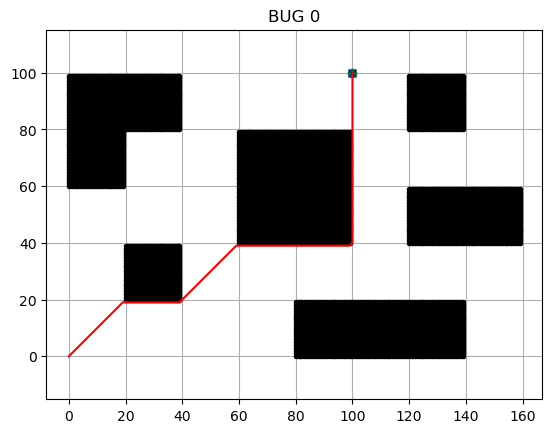

In [12]:
plot_bug(planificador_bug0, obst_xy, 'BUG 0')

## Bug 1

En el algoritmo Bug 2 el robot se mueve hacia el objetivo de forma voraz ("greedy"). Cuando se choca con un obstáculo, se desplaza alrededor del mismo (lo circunnavega) hasta el punto donde se había chocado con el obstáculo. Luego, se retorna al punto sobre el obstáculo que sea más cercano al objetivo y desde allí se inicia el movimiento hacia el objetivo de manera voraz.

In [13]:
class Bug1(BugPlanner):
    def __init__(self, X_start, X_goal, X_obs, show_animation=False):
        super().__init__(X_start[0], X_start[1], X_goal[0], X_goal[1], 
                         X_obs[0], X_obs[1])
        self.show_animation = show_animation

    def run(self):
        mov_dir = 'normal'
        cand_x, cand_y = -np.inf, -np.inf
        exit_x, exit_y = -np.inf, -np.inf
        dist = np.inf
        back_to_start = False
        second_round = False
        if self.show_animation:
            plt.plot(self.x_obs, self.y_obs, ".k")
            plt.plot(self.r_x[-1], self.r_y[-1], "og")
            plt.plot(self.x_goal, self.y_goal, "xb")
            plt.plot(self.out_x, self.out_y, ".")
            plt.grid(True)
            plt.axis('equal')
            plt.title('BUG 1')

        for xob, yob in zip(self.out_x, self.out_y):
            if self.r_x[-1] == xob and self.r_y[-1] == yob:
                mov_dir = 'obs'
                break

        visited_x, visited_y = [], []
        while True:
            if self.r_x[-1] == self.x_goal and \
                    self.r_y[-1] == self.y_goal:
                break
            if mov_dir == 'normal':
                cand_x, cand_y = self.mov_normal()
            if mov_dir == 'obs':
                cand_x, cand_y, back_to_start = \
                    self.mov_to_next_obs(visited_x, visited_y)
            if mov_dir == 'normal':
                found_boundary = False
                for x_ob, y_ob in zip(self.out_x, self.out_y):
                    if cand_x == x_ob and cand_y == y_ob:
                        self.r_x.append(cand_x), self.r_y.append(cand_y)
                        visited_x[:], visited_y[:] = [], []
                        visited_x.append(cand_x), visited_y.append(cand_y)
                        mov_dir = 'obs'
                        dist = np.inf
                        back_to_start = False
                        second_round = False
                        found_boundary = True
                        break
                if not found_boundary:
                    self.r_x.append(cand_x), self.r_y.append(cand_y)
            elif mov_dir == 'obs':
                d = np.linalg.norm(np.array([cand_x, cand_y] -
                                            np.array([self.x_goal,
                                                      self.y_goal])))
                if d < dist and not second_round:
                    exit_x, exit_y = cand_x, cand_y
                    dist = d
                if back_to_start and not second_round:
                    second_round = True
                    del self.r_x[-len(visited_x):]
                    del self.r_y[-len(visited_y):]
                    visited_x[:], visited_y[:] = [], []
                self.r_x.append(cand_x), self.r_y.append(cand_y)
                visited_x.append(cand_x), visited_y.append(cand_y)
                if cand_x == exit_x and \
                        cand_y == exit_y and \
                        second_round:
                    mov_dir = 'normal'
            if self.show_animation:
                plt.plot(self.r_x, self.r_y, "-r")
                plt.pause(0.001)
        if self.show_animation:
            plt.show()

In [15]:
# Posición inicial del robot
X_init = (0.0, 0.0)

# Posición objetivo
X_goal = (100.0, 100.0)

planificador_bug1 = Bug1(X_init, X_goal, obst_xy, show_animation=False)
planificador_bug1.run()

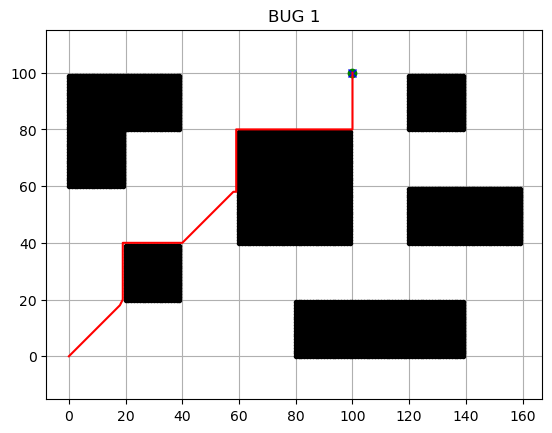

In [16]:
plt.figure()
plot_bug(planificador_bug1, obst_xy, 'BUG 1')

# Nota: si no se muestra animado no se visualizará la circunnavegación

## Bug 2

En este algoritmo el robot se mueve hacia el objetivo de manera voraz. Al chocar con un obstáculo, se mueve alrededor del obstáculo y se registra los valores de la distancia al objetivo. Si la distancia al objetivo disminuye antes y ahora se incrementa, significa que el punto actual probablemente es el punto más cercano al objetivo (podría o no ser verdad debido a que el algoritmo no explora toda la frontera del obstáculo). Luego se parte de este punto y se continúa hacia el objetivo de manera voraz.

In [17]:
class Bug2(BugPlanner):
    def __init__(self, X_start, X_goal, X_obs, show_animation=False):
        super().__init__(X_start[0], X_start[1], X_goal[0], X_goal[1], 
                         X_obs[0], X_obs[1])
        self.show_animation = show_animation

    def run(self):
        mov_dir = 'normal'
        cand_x, cand_y = -np.inf, -np.inf
        if self.show_animation:
            plt.plot(self.x_obs, self.y_obs, ".k")
            plt.plot(self.r_x[-1], self.r_y[-1], "og")
            plt.plot(self.x_goal, self.y_goal, "xb")
            plt.plot(self.out_x, self.out_y, ".")

        straight_x, straight_y = [self.r_x[-1]], [self.r_y[-1]]
        hit_x, hit_y = [], []
        while True:
            if (straight_x[-1] == self.x_goal) and (straight_y[-1] == self.y_goal):
                break
            c_x = straight_x[-1] + np.sign(self.x_goal - straight_x[-1])
            c_y = straight_y[-1] + np.sign(self.y_goal - straight_y[-1])
            for x_ob, y_ob in zip(self.out_x, self.out_y):
                if c_x == x_ob and c_y == y_ob:
                    hit_x.append(c_x), hit_y.append(c_y)
                    break
            straight_x.append(c_x), straight_y.append(c_y)
        if self.show_animation:
            plt.plot(straight_x, straight_y, ",")
            plt.plot(hit_x, hit_y, "d")
            plt.grid(True)
            plt.axis('equal')
            plt.title('BUG 2')

        for x_ob, y_ob in zip(self.out_x, self.out_y):
            if self.r_x[-1] == x_ob and self.r_y[-1] == y_ob:
                mov_dir = 'obs'
                break

        visited_x, visited_y = [], []
        while True:
            if self.r_x[-1] == self.x_goal \
                    and self.r_y[-1] == self.y_goal:
                break
            if mov_dir == 'normal':
                cand_x, cand_y = self.mov_normal()
            if mov_dir == 'obs':
                cand_x, cand_y, _ = self.mov_to_next_obs(visited_x, visited_y)
            if mov_dir == 'normal':
                found_boundary = False
                for x_ob, y_ob in zip(self.out_x, self.out_y):
                    if cand_x == x_ob and cand_y == y_ob:
                        self.r_x.append(cand_x), self.r_y.append(cand_y)
                        visited_x[:], visited_y[:] = [], []
                        visited_x.append(cand_x), visited_y.append(cand_y)
                        del hit_x[0]
                        del hit_y[0]
                        mov_dir = 'obs'
                        found_boundary = True
                        break
                if not found_boundary:
                    self.r_x.append(cand_x), self.r_y.append(cand_y)
            elif mov_dir == 'obs':
                self.r_x.append(cand_x), self.r_y.append(cand_y)
                visited_x.append(cand_x), visited_y.append(cand_y)
                for i_x, i_y in zip(range(len(hit_x)), range(len(hit_y))):
                    if cand_x == hit_x[i_x] and cand_y == hit_y[i_y]:
                        del hit_x[i_x]
                        del hit_y[i_y]
                        mov_dir = 'normal'
                        break
            if self.show_animation:
                plt.plot(self.r_x, self.r_y, "-r")
                plt.pause(0.001)
        if self.show_animation:
            plt.show()

In [18]:
# Posición inicial del robot
X_init = (0.0, 0.0)

# Posición objetivo
X_goal = (100.0, 100.0)

planificador_bug2 = Bug2(X_init, X_goal, obst_xy)
planificador_bug2.run()

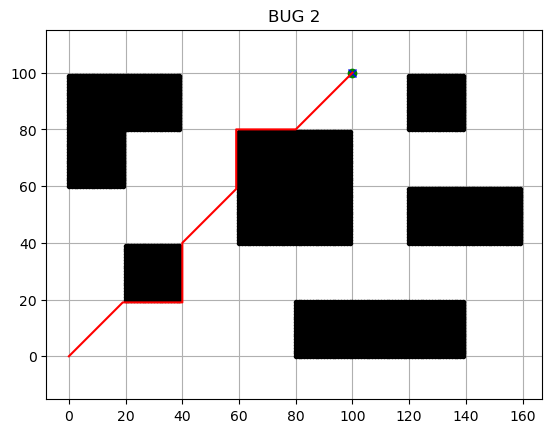

In [19]:
plot_bug(planificador_bug2, obst_xy, 'BUG 2')